In [2]:
import json
import os
import types
import zipfile

import numpy
import pandas
import tensorflow as tf

from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import models

2024-03-26 11:22:10.017169: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 11:22:10.019439: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 11:22:10.049356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 11:22:10.700089: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
data_folder = 'data_nordic/'

segments, labels = [], []
one_hot_encoding = {}

for filename in os.listdir(data_folder):
    if filename.endswith('.csv'):
        try:
            file_data = pandas.read_csv(os.path.join(data_folder, filename))

            for _, row in file_data.iterrows():
                segment_data = row[['X', 'Y', 'Z']].values
                label = row['Label']

                if label not in one_hot_encoding:
                    one_hot_encoding[label] = len(one_hot_encoding)

                segments.append(segment_data)
                labels.append(one_hot_encoding[label])

        except FileNotFoundError:
            pass

max_length = min(len(segment) for segment in segments)
x = numpy.array([segment[:max_length] for segment in segments]) / 1000
y = tf.keras.utils.to_categorical(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.85, stratify=y)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# x_train = (x_train - numpy.mean(x_train)) / numpy.std(x_train)
# x_test = (x_test - numpy.mean(x_test)) / numpy.std(x_test)

In [20]:
x.shape

(11156, 3)

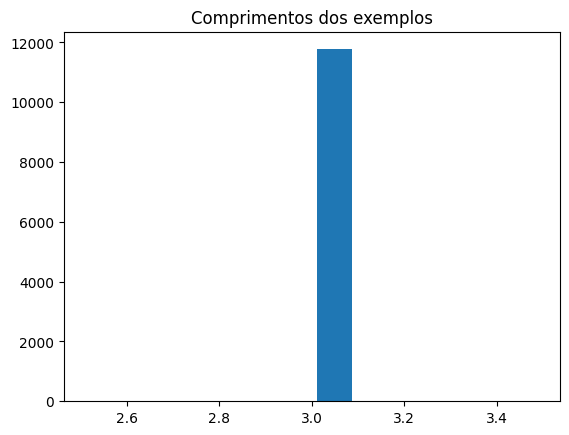

In [4]:
pyplot.title('Comprimentos dos exemplos')
lengths = numpy.array([len(segment) for segment in segments])
pyplot.hist(lengths, rwidth=0.75, bins=10)

pyplot.show()

[1, 2, 0] [3278 3352 3375]
[1, 2, 0] [579 591 596]


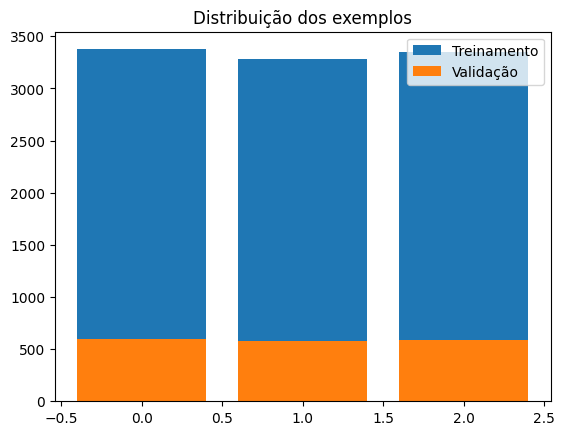

In [5]:
labels = list(one_hot_encoding.keys())

pyplot.title('Distribuição dos exemplos')

height =  numpy.histogram(y_train.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Treinamento')

height =  numpy.histogram(y_test.argmax(axis=1), bins=len(labels))[0]
print(labels, height)
pyplot.bar(labels, height, label='Validação')

pyplot.legend()
pyplot.show()

In [6]:
# Adicionando uma dimensão extra para os canais
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Defina a arquitetura da rede neural
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.Conv1D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(one_hot_encoding), activation='softmax')
])

# Compile o modelo")

model.compile(loss='categorical_crossentropy',
              metrics=['acc'])

# Treine o modelo
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100


2024-03-26 11:22:24.937760: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-26 11:22:24.938369: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - acc: 0.4409 - loss: 1.0523 - val_acc: 0.5102 - val_loss: 0.9847
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - acc: 0.5195 - loss: 0.9624 - val_acc: 0.5515 - val_loss: 0.9367
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - acc: 0.5443 - loss: 0.9200 - val_acc: 0.5730 - val_loss: 0.9034
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - acc: 0.5825 - loss: 0.8906 - val_acc: 0.5917 - val_loss: 0.8792
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - acc: 0.5824 - loss: 0.8725 - val_acc: 0.5906 - val_loss: 0.8645
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - acc: 0.5795 - loss: 0.8641 - val_acc: 0.5855 - val_loss: 0.8540
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - acc: 0.6013 - loss: 0.8373 - val_acc: 0.5991 - val_loss: 0.8438
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - acc: 0.5820 - loss: 0.8536 - val_acc: 0.6048 - val_loss: 0.8391
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 

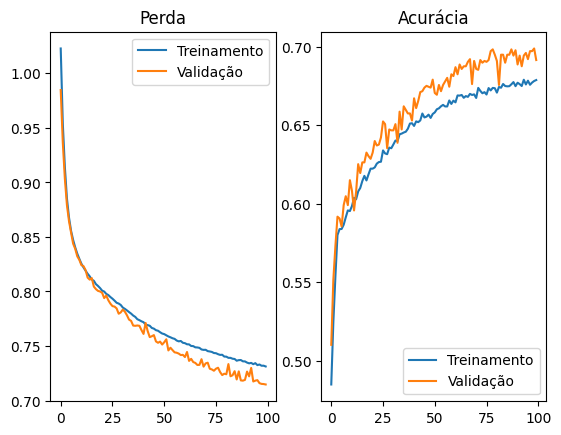

In [7]:
fig, ax = pyplot.subplots(1, 2)

ax[0].set_title('Perda')
ax[0].plot(history.epoch, history.history['loss'], label='Treinamento')
ax[0].plot(history.epoch, history.history['val_loss'], label='Validação')
ax[0].legend()

ax[1].set_title('Acurácia')
ax[1].plot(history.epoch, history.history['acc'], label='Treinamento')
ax[1].plot(history.epoch, history.history['val_acc'], label='Validação')
ax[1].legend()

pyplot.show()

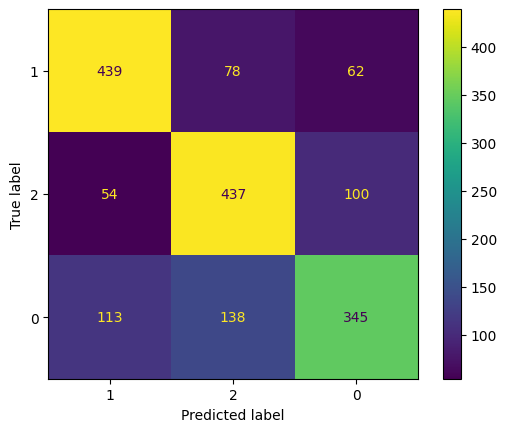

,1,2,0,accuracy,macro avg,weighted avg
precision,0.724422,0.669219,0.680473,0.691393,0.691372,0.691116
recall,0.758204,0.739425,0.578859,0.691393,0.692163,0.691393
f1-score,0.740928,0.702572,0.625567,0.691393,0.689689,0.689159
support,579.000000,591.000000,596.000000,0.691393,1766.000000,1766.000000


In [8]:
y_pred = model.predict(x_test, verbose=0).argmax(axis=1)
y_true = y_test.argmax(axis=1)

labels = list(one_hot_encoding.keys())
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize=None, display_labels=labels)
pyplot.show()

pandas.DataFrame.from_dict(classification_report(y_true, y_pred, target_names=labels, output_dict=True))

In [9]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
            numpy.product(list(map(int, v.shape))) * v.dtype.size
            for v in model.trainable_variables
    ]
    print("Model size:", sum(var_sizes) / 1024, "KB")


calculate_model_size(model)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 32)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456 (1.79 KB)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 229 (920.00 B)

None


/tmp/ipykernel_132258/2962487377.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  var_sizes = [


AttributeError: 'str' object has no attribute 'size'

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("model_quantized.tflite", "wb").write(tflite_model)

basic_model_size = os.path.getsize("model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

INFO:tensorflow:Assets written to: /tmp/tmpnxrsibsl/assets


INFO:tensorflow:Assets written to: /tmp/tmpnxrsibsl/assets


: 